# MnMS : Multimodal Network Modelling and Simulation

## Create a grid of roads

In [1]:
# Install a conda package in the current Jupyter kernel
import sys
# !conda install --yes --prefix {sys.prefix} shapely

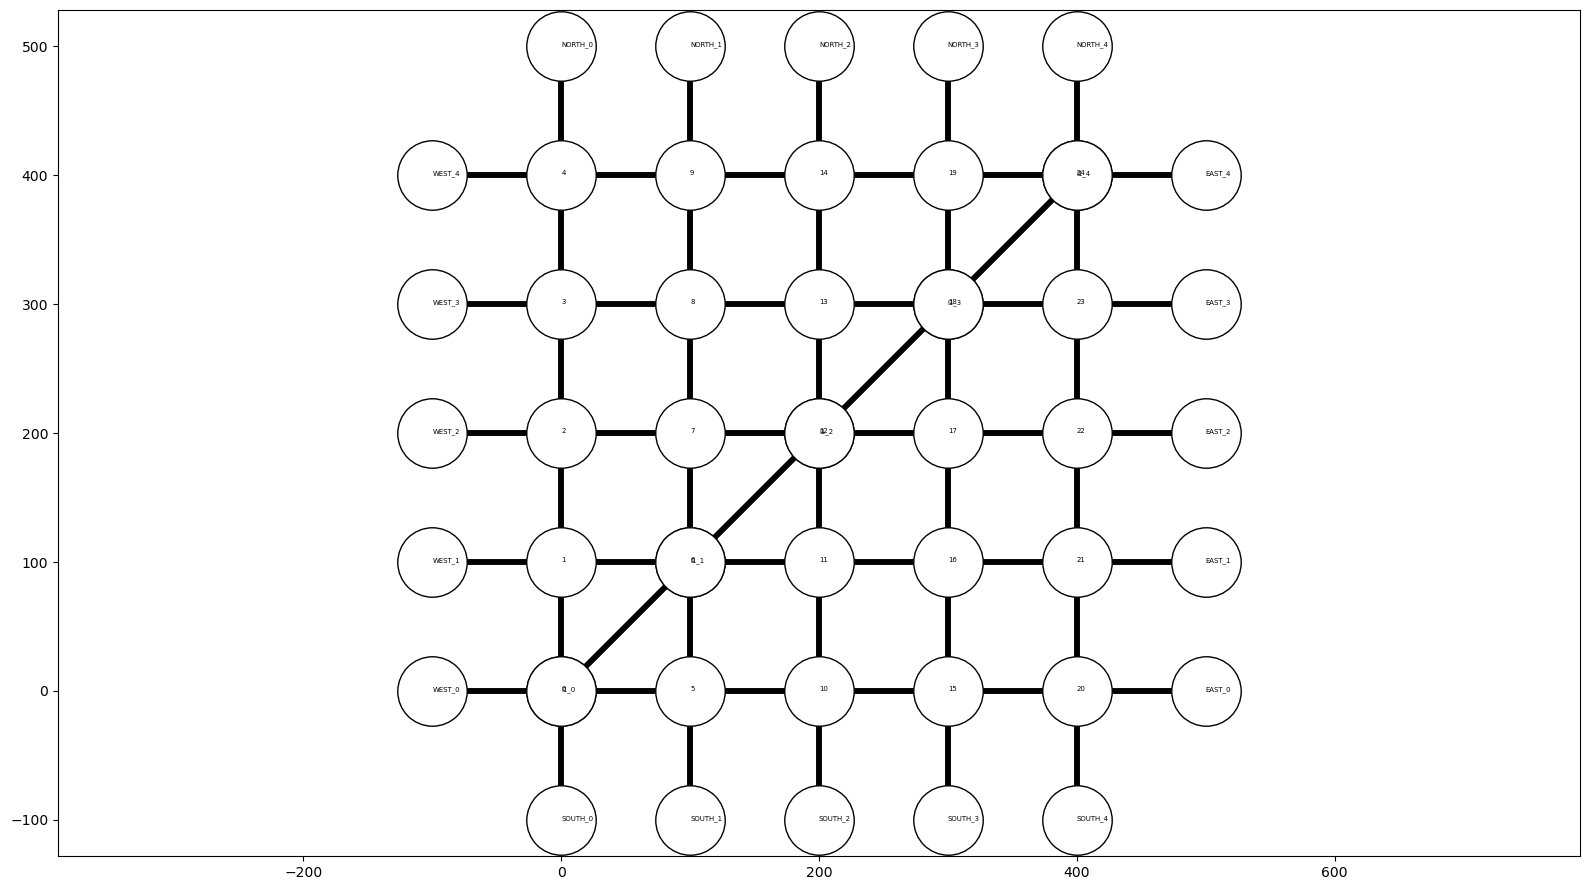

In [6]:
import matplotlib.pyplot as plt

from mnms.generation.roads import generate_manhattan_road, generate_pt_line_road
from mnms.tools.render import draw_roads

# generate_manhattan_passenger_car(n, link_length)
# n : Number of point in x and y direction
# link_length : the length of the links
roads = generate_manhattan_road(5, 100)
ptroads = generate_pt_line_road(roads, start=[0,0], end=[400,400], n=5, line_id='l1', length=400)

fig, ax = plt.subplots(figsize=(16, 9))
draw_roads(ax, roads, linkwidth=4, nodesize=50)


## Add a "Personal car" mobility service

In [2]:
#import sys
sys.path.append('/Users/mnemer/Desktop/MnMS-folder/MnMS/src/hipop/cpp')
sys.path

['/Users/mnemer/Desktop/MnMS-folder/MnMS/doc/tutorials',
 '/opt/anaconda3/lib/python312.zip',
 '/opt/anaconda3/lib/python3.12',
 '/opt/anaconda3/lib/python3.12/lib-dynload',
 '',
 '/opt/anaconda3/lib/python3.12/site-packages',
 '/opt/anaconda3/lib/python3.12/site-packages/aeosa',
 '/Users/mnemer/Desktop/MnMS-folder/MnMS/src',
 '/Users/mnemer/Desktop/MnMS-folder/MnMS/src/hipop/cpp']

In [4]:
from mnms.generation.layers import generate_layer_from_roads
from mnms.mobility_service.personal_vehicle import PersonalMobilityService


car_service = PersonalMobilityService('perso')

ModuleNotFoundError: No module named 'hipop.cpp.shortest_path'

## Add a "uber" mobility service

In [17]:
from mnms.mobility_service.on_demand import OnDemandDepotMobilityService

uber_service=OnDemandDepotMobilityService('uber', 0)

ModuleNotFoundError: No module named 'hipop.cpp.shortest_path'

## Create the "CAR" layer

In [13]:
from mnms.graph.layers import CarLayer

car_layer = generate_layer_from_roads(roads, "CAR", mobility_services=[car_service,uber_service])

ModuleNotFoundError: No module named 'hipop.cpp.shortest_path'

## Create an OD Layer

In [ ]:
from mnms.generation.layers import generate_matching_origin_destination_layer

odlayer = generate_matching_origin_destination_layer(roads)

## Create a Multi Layer Graph

In [ ]:
from mnms.graph.layers import MultiLayerGraph

# MultiLayerGraph(layers, odlayer, connection_distance)
#mlgraph = MultiLayerGraph([car_layer, uber_service], odlayer, 1e-5)
mlgraph = MultiLayerGraph([car_layer], odlayer, 1e-5)

mlgraph.graph.nodes

## Generate a demand

In [19]:
from mnms.generation.demand import generate_random_demand
from mnms.tools.observer import CSVUserObserver

demand = generate_random_demand(mlgraph,
                                50,
                                tstart="9:00:00", 
                                tend="11:00:00", 
                                min_cost=0.4)

demand.add_user_observer(CSVUserObserver("user.csv"))
# demand.show_users()

ModuleNotFoundError: No module named 'hipop.cpp.shortest_path'

## Load the demand in MnMS

In [ ]:
from mnms.time import Time

users = demand.get_next_departures(Time("09:00:00"), Time("11:00:00"))

## Create a decision model

In [ ]:
from mnms.travel_decision import LogitDecisionModel
from mnms.travel_decision.abstract import Event

travel_decision = LogitDecisionModel(mlgraph,
                                     cost="travel_time",
                                     theta=0.01,
                                     n_shortest_path=2, outfile="path.csv")


In [ ]:
for user in users[:3]:
    print(f"{user}, path: {user.path}")

In [ ]:
travel_decision.add_users_for_planning(users, [Event.DEPARTURE]*len(users))

In [ ]:
for user in users:
    travel_decision(user.departure_time)

for user in users:
    if user.path is not None:
        print(f"{user}, services: {user.path.mobility_services}")
    else:
        print(f"{user}: no path")

## Render the path

In [ ]:
from mnms.tools.render import draw_path

for user in users[:3]:
    fig, ax = plt.subplots(figsize=(16, 9))
    draw_roads(ax, mlgraph.roads, linkwidth=4, nodesize=10)
    draw_path(ax, mlgraph, user.path)

## Create a MFD function

In [ ]:
def v_MFD(acc):
    V = 0
    N = acc["CAR"]
    
    if N < 10:
        V = 14
    elif N < 20:
        V = 12
    elif N < 50:
        V = 10
    else:
        V = 5
        
    V_BUS = 100
    return {"CAR": V, "BUS": V_BUS}

## Add a flow motor

In [ ]:
from mnms.flow.MFD import Reservoir, MFDFlowMotor

flow_motor = MFDFlowMotor()
res = Reservoir(mlgraph.roads.zones["RES"], ["CAR", "BUS"], v_MFD)
flow_motor.add_reservoir(res)

## Create a supervisor

In [ ]:
from mnms.simulation import Supervisor

supervisor = Supervisor(mlgraph,
                        demand,
                        flow_motor,
                        travel_decision,
                        outfile="travel_time_link.csv")

## Run the simulation

In [ ]:
from mnms.time import Time, Dt

supervisor.run(Time("09:00:00"),
               Time("12:00:00"),
               Dt(minutes=1),
               1)